In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from decimal import Decimal
from math import pi
from numpy import nan
from scipy import signal
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from math import pi, sqrt, cos, sin
import math
import random
from math import fmod
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as savitzky_golay

from matplotlib import rc
import matplotlib.gridspec as gridspec
from scipy.signal import savgol_filter as savitzky_golay

import numba 
from numba import jit 
from numba.typed import List

params    = { r'text.latex.preamble': [r'\usepackage{siunitx}', r'\usepackage{lmodern}'
              r'\sisetup{detect-family = true}',
              r'\usepackage{amsmath}'],
              'text.usetex'    : True, 
              "font.family": "DeJaVu Sans",           
              "font.monospace": [],          
              'axes.labelsize' : 19,
              'font.size'  : 19,
              'legend.fontsize': 20,
              'xtick.labelsize': 19,
              'ytick.labelsize': 19,
              'axes.linewidth' : 1.,
              "lines.linewidth" : 2.
              }

matplotlib.rcParams.update(params)

colors = ['#9467bd','#1f77b4','#ff7f0e','#2ca02c','#d62728',
          '#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

blues, bupu = cm.get_cmap('Blues'), cm.get_cmap('BuPu')
rev_blues, rev_bupu = blues.reversed(), bupu.reversed()

In [17]:
'''Function to say True or False (1 or 0) whether a system is in a given state based on the order parameters'''

def state(r1, r2, state):
    if state == 'sync':
        if (r1 > 0.96 and r2 > 0.96):
            return 1
        else:
            return 0
        
    if state == 'chim':
        if ((0.7 < r1 < 0.82) and (0.7 < r2 < 0.82)):
            return 1
        else:
            return 0
        
    if state == 'mix':
        if (((0.7 < r1 < 0.82) and (r2 > 0.96)) or ((r1 > 0.96) and (0.7 < r2 < 0.82))):
            return 1
        else:
            return 0
    
    if state == 'mix1':
        if (((0.7 < r1 < 0.82) and (r2 > 0.96))):
            return 1
        else:
            return 0
        
    if state == 'mix2':
        if (((r1 > 0.96) and (0.7 < r2 < 0.82))):
            return 1
        else:
            return 0
        
    if state == 'misc':
        if not (((0.7 < r1 < 0.82) and (r2 > 0.96)) or ((r1 > 0.96) and (0.7 < r2 < 0.82))
               or ((0.7 < r1 < 0.82) and (0.7 < r2 < 0.82)) 
               or (r1 > 0.96 and r2 > 0.96)):
            return 1
        else:
            return 0
    else:
        print ("Valid states are sync, chim, mix and misc")
        
'''Function to categorize system into states based on order parameters.
   States are labeled 0: 'mix', 1: 'sync', 2: 'chim', 3: incoherent'''
        
def states(r1, r2):
    
    if (r1 > 0.96 and r2 > 0.96):
        return 1
    
    elif ((0.6 < r1 < 0.96) and (0.6 < r2 < 0.96)):
        return 2
    
    elif (((0.6 < r1 < 0.96) and (r2 > 0.96)) or ((r1 > 0.96) and (0.6 < r2 < 0.96))):
        return 0
    
    else: 
        return 3

'''To calculate local order parameters from the phases'''

@jit(nopython=True)
def calc_mean_field( x, r, i ):
    
    cos_sum, sin_sum = 0, 0
    for j in range(len(x)):
        dist = abs(j-i);
        dist = abs(dist - round(dist/len(x)) * len(x))
        
        if(dist <= r and dist > 0):
            cos_sum += cos( x[j] )
            sin_sum += sin( x[j] )
            
    cos_sum /= ( 2 * r )
    sin_sum /= ( 2 * r )
        
    R = sqrt( cos_sum**2 + sin_sum**2 )
    Theta = np.arctan2( abs(sin_sum) , abs(cos_sum) )
        
    return(R, Theta)

'''To calculate the sum of the order parameters'''

@jit(nopython=True)
def order(phi1, phi2):
    r1, r2 = 0, 0 
    th1, th2 = 0, 0
    
    for i in range(200):
        a1, b1 = calc_mean_field( phi1 , 70, i )
        a2, b2 = calc_mean_field( phi2 , 70, i )
        r1 += a1
        th1 += b1
        r2 += a2
        th2 += b2
        
    return(r1, r2, th1, th2)

'''To calculate the interlayer order parameters'''

@jit(nopython=True)
def ord_int(phi1, phi2):
    
    Rint = 0
    for i in range(200):
        cos_sum = (cos( phi1[i] ) + cos( phi2[i] ))/2
        sin_sum = (sin( phi1[i] ) + sin( phi2[i] ))/2
        Rint += sqrt( cos_sum**2 + sin_sum**2 )
        
    return(Rint/200)

@jit(nopython=True)
def loc_order(phi1, phi2):
    r1, r2 = [], [] 
    
    for i in range(200):
        r1.append(calc_mean_field( phi1 , 70, i ))
        r2.append(calc_mean_field( phi2 , 70, i ))
        
    return(r1, r2)

'''Create periodic boundaries [-pi,pi]'''

def osc_mod(x):
    phi = [s%(2*pi) for s in x]

    for k in range(len(phi)):
        if(phi[k] >= pi):
            phi[k] = phi[k] -2*pi

    return(phi)

In [ ]:
col_dict={0:"orange",
          1:"blue",
          2:"red", 
          3:"grey"} 
    
labels = np.array(["Mix", "Sync", "Chim", "Incoh."]) 

len_lab = len(labels)

col_dict2={0:"orange",
          1:"blue",
          2:"red"} 
    
labels2 = np.array(["Mix", "Sync", "Chim"]) 
len_lab2 = len(labels2)

def smoothing(data, smoothness=0.5):
    last = data[0]
    new_data = [data[0]]
    for datum in data[1:]:
        new_value = smoothness * last + (1 - smoothness) * datum
        new_data.append(new_value)
        last = datum
    return new_data

## Deterministic system

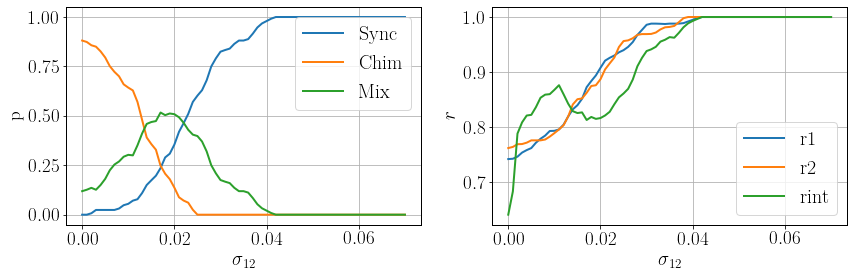

In [4]:
'''Create plots of the probability of being in a given state'''

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=False) 

path = 'output_of_cpp_file.txt'

data = pd.read_csv(path, sep='\t', names=['sig12', 'seed', 'Rint', 'delta', 'om', 'R1', 'R2'])

data['sync'] = data.apply(lambda row: state(row.R1, row.R2, 'sync') , axis=1)
data['chim'] = data.apply(lambda row: state(row.R1, row.R2, 'chim') , axis=1)
data['mix']  = data.apply(lambda row: state(row.R1, row.R2, 'mix')  , axis=1)
data['misc'] = data.apply(lambda row: state(row.R1, row.R2, 'misc') , axis=1)

synclist, chimlist, mixlist, misclist  = [], [], [], []
R1list, R2list, Rintlist = [], [], []

data0 = data
    
for sig in range(71):
    sig = round(0.001*sig, 3)
    data1 = data0[data0['sig12'] == sig]  

    data2 = data1
        
    synclist.append(round(data2['sync'].mean(), 3))
    chimlist.append(round(data2['chim'].mean(), 5))
    mixlist.append(round(data2['mix'].mean(), 3))
    misclist.append(round(data2['misc'].mean(), 3))

data_m = data
    
for sig in range(71):
    sig = round(0.001*sig, 3) 
        
    data1_m = data_m[data_m['sig12'] == sig]
        
    data2_m = data1_m
        
    Rintlist.append(round(data2_m['Rint'].mean(), 3))
    R1list.append(round(data2_m['R1'].mean(), 3))
    R2list.append(round(data2_m['R2'].mean(), 3))

siglist = np.arange(0,0.071,0.001).tolist() 

ax1.plot(siglist, synclist, linewidth=2, label=r'Sync') 
ax1.plot(siglist, chimlist, linewidth=2, label=r'Chim') 
ax1.plot(siglist, mixlist, linewidth=2, label=r'Mix')

ax1.legend(loc='best')
ax1.set_xlabel(r'$\sigma_{12}$')
ax1.set_ylabel(r'p')

ax2.plot(siglist, R1list, markersize=5,label=r'r1')
ax2.plot(siglist, R2list, markersize=5,label=r'r2')
ax2.plot(siglist, Rintlist, markersize=5,label=r'rint')
ax2.set_ylabel(r'$r$')
ax2.set_xlabel(r'$\sigma_{12}$')
ax2.legend(loc='lower right')

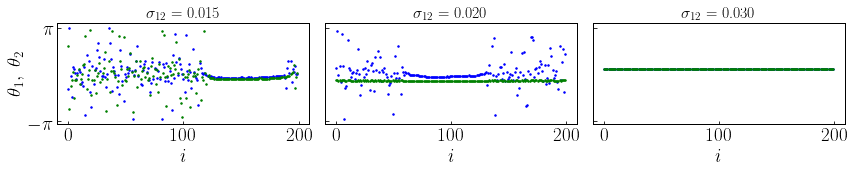

In [5]:
"Plot snapshots of the system"

st = '/Users/'
plot = 1
seed = 378999

f, axs = plt.subplots(1, 3, figsize=(12,2.5), sharey=True) #5,7
slist = [0.015, 0.02, 0.03]
shlist = [2.5,0.5,-2.5]

for t in range(3):
    
    if t == 0: path = st + 'shiftchim_n200_r70_g0_tplot_{}_seed{}_lone1_ltwo0.015.txt'.format(plot, seed)
    if t == 1: path = st + 'shiftchim_n200_r70_g0_tplot_{}_seed{}_lone1_ltwo0.02.txt'.format(plot, seed)
    if t == 2: path = st + 'shiftchim_n200_r70_g0_tplot_{}_seed{}_lone1_ltwo0.03.txt'.format(plot, seed)
    
    data = pd.read_csv(path, sep='\t', names=['D', 'sig12', 't', 'i', 'phi2', 'phi1', 'om2', 'om1'])
    
    data1 = data[data['t']==89] 
    
    x, phi1, phi2 = data1['i'].tolist(), data1['phi1'].tolist(), data1['phi2'].tolist()
    
    phi1 = [x - shlist[t] for x in phi1]
    phi2 = [x - shlist[t] for x in phi2]
    
    
    phi1 = osc_mod(phi1)
    phi2 = osc_mod(phi2)  
    
    phi = np.subtract(phi2,phi1)
    
    phi = [s%(2*pi) for s in phi]
    for i in range(len(x)):
        if(phi[i] > pi): 
            phi[i] = phi[i] -2*pi 
    
    axs[t].plot(x, phi1,'.b', markersize=3)
    axs[t].plot(x, phi2,'.g', markersize=3)
    axs[0].set_ylabel(r'$\theta_{1},~ \theta_{2}$')
    axs[t].set_xlabel(r'$i$')
    axs[t].set_title(r'$\sigma_{12}$ = %1.3f' %slist[t], fontsize=16) 
    axs[t].set_yticks([-np.pi,np.pi])
    axs[t].set_yticklabels([r'$-\pi$', r'$\pi$'])
    axs[t].tick_params(direction="in")

f.tight_layout()

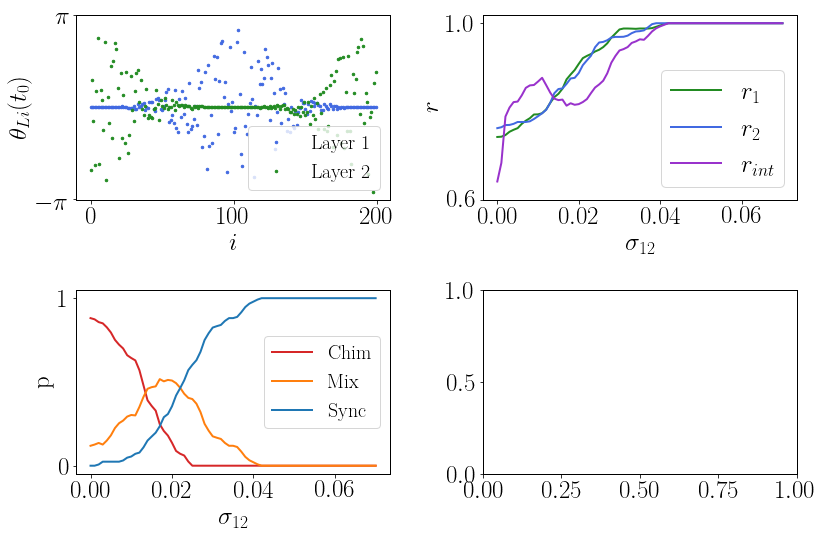

In [6]:
"Plot everything neatly with Gridspec"

rc('text', usetex=True)
rc('xtick', labelsize=25)
rc('ytick', labelsize=25)

rc('font', size=25)
rc('axes', labelsize=25)

fig=plt.figure(figsize=[12,8])
gs = gridspec.GridSpec(6,6, figure=fig)

plt.subplots_adjust(wspace=0.1, hspace=.2)

ax11=fig.add_subplot(gs[0:3,0:3]) 
ax12=fig.add_subplot(gs[0:3,3:6])
ax21=fig.add_subplot(gs[3:6,0:3]) 
ax22=fig.add_subplot(gs[3:6,3:6])

N = 200
x = list(range(1,201))

y1 = 6*(np.random.random(N)-0.5)*np.exp(-0.76*np.linspace(-np.pi,np.pi,N)**2) # initial conditions
y2 = 6*(np.random.random(N)-0.5)*np.exp(-0.76*np.linspace(-np.pi,np.pi,N)**2)
y2 = np.roll(y2,N/2) # shift the chimera 

s = 0.7

ax11.plot(x, y2,'.', color='royalblue', markersize=5, label=r'Layer 1')
ax11.plot(x, y1,'.', color='forestgreen', markersize=5,label=r'Layer 2')
ax11.set_ylabel(r'$\theta_{Li} (t_{0})$')
ax11.set_xlabel(r'$i$')
ax11.set_yticks([-np.pi,np.pi])
ax11.set_yticklabels([r'$-\pi$',r'$\pi$'])
ax11.legend(loc='best')

ax21.plot(siglist, smoothing(chimlist, s), 'tab:red', linewidth=2, label=r'Chim') 
ax21.plot(siglist, smoothing(mixlist, s), 'tab:orange', linewidth=2, label=r'Mix')
ax21.plot(siglist, smoothing(synclist, s), 'tab:blue', linewidth=2, label=r'Sync') 

ax21.set_yticks([0,1])
ax21.legend(loc='right')
ax21.set_xlabel(r'$\sigma_{12}$')
ax21.set_ylabel(r'p')

ax12.plot(siglist, smoothing(R1list, s), 'forestgreen', markersize=5,label=r'$r_1$')
ax12.plot(siglist, smoothing(R2list, s), 'royalblue', markersize=5,label=r'$r_2$')
ax12.plot(siglist, smoothing(Rintlist, s), color='darkorchid', markersize=6,label=r'$r_{int}$')

ax12.set_yticks([0.6,1])
ax12.set_ylabel(r'$r$')
ax12.set_xlabel(r'$\sigma_{12}$')
ax12.legend(loc='lower right', fontsize=25)

fig.tight_layout()

## Time Plot

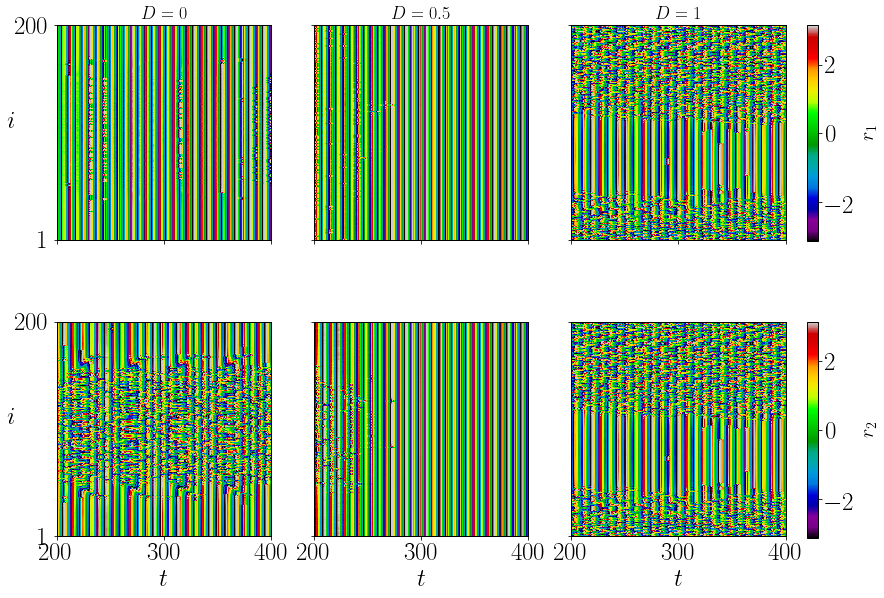

In [7]:
"Time plots"

normalizer=Normalize(-pi,pi) 
im=cm.ScalarMappable(norm=normalizer)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharex=True, sharey=True)
fig.subplots_adjust(right=0.8)

plot = 2 
st = '/Users/'

for j in range(3):
    if j == 0: data = np.loadtxt(st + '1sy1ch_n200_r70_g0_tplot_{}_a0p01_seed378099_lone1_ltwo0.04_om0_fr1_Dfr0.txt'.format(plot))
    elif j == 1: data = np.loadtxt(st + '1sy1ch_n200_r70_g0_tplot_{}_a0p01_seed378099_lone1_ltwo0.04_om0_fr1_Dfr0.5.txt'.format(plot))
    elif j == 2: data = np.loadtxt(st + '1sy1ch_n200_r70_g0_tplot_{}_a0p01_seed378099_lone1_ltwo0.04_om0_fr1_Dfr1.txt'.format(plot))    
        
    data = pd.DataFrame(data, columns = ['D', 'lamb2', r'$t$', r'$i$', r'$\phi_2$', r'$\phi_1$', r'$\omega_2$', r'$\omega_1$'])
        
    phi1 = data[r'$\phi_1$']
    phi2 = data[r'$\phi_2$']

    phi1 = osc_mod(phi1)
    phi2 = osc_mod(phi2) 
            
    r1, r2 = [], []
    
    for t in range(200):
        
        phi_1, phi_2 = List(), List()
        
        a, b = 200*t,200*t + 199
        [phi_1.append(x) for x in phi1[a:b]] 
        [phi_2.append(x) for x in phi2[a:b]]
    
        # To make time plots of the local order parameter
        r1t, r2t = loc_order(phi_1, phi_2) 
        
        r1.append(r1t) 
        r2.append(r2t) 
        
    z = np.array(phi1) 
    z = z.reshape(200, 200)
    z = np.array(z).T
    
    im = ax[0,j].imshow(z, cmap='nipy_spectral', norm=normalizer, interpolation='sinc') #norm=normalizer 
    ax[0,j].set_xticks([0,200])
    start, end = (plot - 1)*200, plot*200
    mid = int((start + end)/2)
    ax[0,j].set_xticklabels([r'{}'.format(start),r'{}'.format(end)])
    ax[0,j].invert_yaxis()
    
    z = np.array(phi2) 
    z = z.reshape(200, 200)
    z = np.array(z).T
    
    im2 = ax[1,j].imshow(z, extent=(0, 0.1, 0, 0.1), cmap='nipy_spectral', norm=normalizer, interpolation='sinc') #, norm=normalizer2 
    ax[1,j].set_xticks([0.0,0.05, 0.1])
    ax[1,j].set_xticklabels([r'{}'.format(start), r'{}'.format(mid), r'{}'.format(end)])
    ax[1,j].invert_yaxis()
    
ax[0,0].set_yticks([0.1,0.0])
ax[0,0].set_ylabel(r'$i$', rotation= 0) 

ax[1,0].set_yticks([0.1,0.0])
ax[1,0].set_yticklabels([r'1',r'200'])
ax[1,0].set_ylabel(r'$i$', rotation= 0) 

ax[1,0].set_xlabel(r'$t$')
ax[1,1].set_xlabel(r'$t$')
ax[1,2].set_xlabel(r'$t$')

ax[0,0].set_title(r'$D = 0$', fontsize=18)
ax[0,1].set_title(r'$D = 0.5$', fontsize=18)
ax[0,2].set_title(r'$D = 1$', fontsize=18)

cbar_ax = fig.add_axes([(0.82), (0.557), (0.01), (0.3)])
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), cax=cbar_ax) 
cbar.set_label(r'$r_1$', fontsize=20) 

cbar_ax2 = fig.add_axes([(0.82), (0.145), (0.01), (0.3)])
cbar2 = fig.colorbar(im2, ax=ax.ravel().tolist(), cax=cbar_ax2) 
cbar2.set_label(r'$r_2$', fontsize=20) 

plt.show()

In [ ]:
'''Code for plotting order parameters and calculating breathing period'''

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(5,11), sharey=True)
fig.subplots_adjust(right=0.8)

st = '/Users/'

for i in range(5):
    
    if i == 0: s12 = 0
    else: s12 = round(i*0.01, 3)
    
    R1, R2, Rint = [], [], []
    Th1, Th2, Thd = [], [], []
        
    for plot in range(1,2):
        data = np.loadtxt(st + 'tplot_{}_seed377999_lone1_ltwo{}.txt'.format(plot, s12))
        data = pd.DataFrame(data, columns = ['D', 'lamb2', 't', 'i', 'phi2', 'phi1', 'om2', 'om1'])
        
        for t in range(200):
            
            data1 = data[data['t'] == t]
            
            phi1, phi2 = np.array(data1['phi1']), np.array(data1['phi2'])
            
            r1, r2, th1, th2 = order(phi1, phi2)
            rint = ord_int(phi1, phi2)
            
            R1.append(r1 / 200); Th1.append(th1 / 200)
            R2.append(r2 / 200); Th2.append(th2 / 200)
            Rint.append(rint); Thd.append((th2 - th1)/200)
                
    mean = (max(Rint) + min(Rint))/2
        
    count = 0
    for k in range(len(Rint)-1):
        if Rint[k] > mean and Rint[k+1] < mean:
            count += 1
                
    A = float(count)

    ax[i].plot(Rint, linewidth=2, label=r'$r_{int}$')
    ax[i].plot(Thd, linewidth=2, label=r'$\Delta \Theta$')
    ax[i].set_xlabel(r'$t$')
    ax[i].set_xticks([0, 50, 100, 150, 200])
    ax[i].set_xlim([0, 100])

ax[4].legend(ncol=1, loc='right', prop={'size': 16.7})
plt.rc('legend',fontsize=26)

fig.tight_layout()

plt.show()

In [ ]:
'''Fitting breathing period T'''

tdlist = [] 

def sniper(x, a, b):
    del_om = 2*pi/tdlist[0]
    
    return (2*pi/np.sqrt(del_om**2 - b*(x**2)))

tdlist = np.array(tdlist)
Dlist = np.arange(0,0.32,0.02) 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True)
ax.plot(Dlist, tdlist, '.')
ax.set_ylabel('T')
ax.set_xlabel(r'$D$')

popt, pcov = curve_fit(sniper, Dlist, tdlist, bounds=([-100,-100], [100, 100])) 
print(popt)

ax.plot(Dlist, sniper(Dlist, *popt), 'g--', 
        label=r'$T(D) = \\ \frac{2\pi}{\sqrt{(\Delta \omega_{\sigma})^2 - bD^2}}$') 
plt.legend(prop={'size': 30}, fontsize=30, framealpha=1)


<ipython-input-19-81a20231290b>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


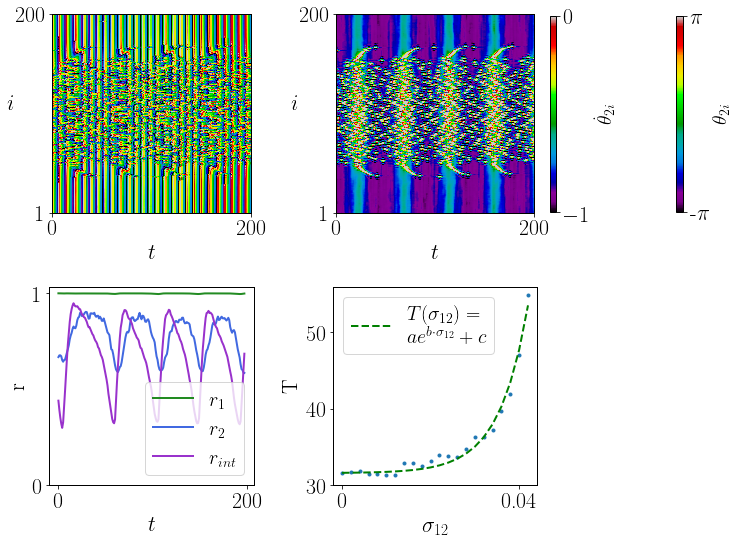

In [19]:
'''Another Gridspec figure'''

fig=plt.figure(figsize=[8,8])
gs = gridspec.GridSpec(2,2, figure=fig)

plt.subplots_adjust(wspace=-.6, hspace=.2)

ax11=fig.add_subplot(gs[0,0]) 
ax12=fig.add_subplot(gs[0,1])

ax21=fig.add_subplot(gs[1,0]) 
ax22=fig.add_subplot(gs[1,1])

normalizer=Normalize(-pi,pi)
im=cm.ScalarMappable(norm=normalizer)
im = ax11.imshow(z1, extent=(0, 0.1, 0, 0.1), cmap='nipy_spectral', norm=normalizer, interpolation='sinc') #norm=normalizer 
ax11.set_xticks([0.0,0.1])
ax11.set_xticklabels([r'0',r'200'])
ax11.invert_yaxis()

normalizer=Normalize(-1,0) 
im2=cm.ScalarMappable(norm=normalizer)
im2 = ax12.imshow(z2, extent=(0, 0.1, 0, 0.1), cmap='nipy_spectral', norm=normalizer, interpolation='sinc') #norm=normalizer 
ax12.set_xticks([0.0,0.1])
ax12.set_xticklabels([r'0',r'200'])
ax12.invert_yaxis()

ax11.set_yticks([0.1,0.0])
ax11.set_yticklabels([r'1',r'200'])
ax11.set_ylabel(r'$i$', rotation= 0) 
ax11.set_xlabel(r'$t$')

ax12.set_yticks([0.1,0.0])
ax12.set_yticklabels([r'1',r'200'])
ax12.set_ylabel(r'$i$', rotation= 0) 
ax12.set_xlabel(r'$t$')

cbar_ax = fig.add_axes([(1.2), (0.602), (0.011), (0.34)])
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), ticks=[-np.pi,np.pi], cax=cbar_ax)
cbar.ax.set_yticklabels([r'-$\pi$', r'$\pi$'])
cbar.set_label(r'$\theta_{2i}$', fontsize=20) 

cbar_ax2 = fig.add_axes([(0.98), (0.602), (0.011), (0.34)])
cbar2 = fig.colorbar(im2, ax=ax.ravel().tolist(), ticks=[-1,0], cax=cbar_ax2) 
cbar2.set_label(r'$\dot{\theta}_{2i}$', fontsize=20) 

ax21.plot(R1[0:198], 'forestgreen', linewidth=2, label=r'$r_1$')
ax21.plot(R2[0:198], 'royalblue', linewidth=2, label=r'$r_2$')
ax21.plot(Rint[0:198], 'darkorchid', linewidth=2, label=r'$r_{int}$')

ax21.set_yticks([0,1])
ax21.set_xticks([0, 200])
ax21.legend(loc='lower right', fontsize=20)
ax21.set_xlabel(r'$t$')
ax21.set_ylabel(r'r')

ax22.plot(siglist, tlist, '.')  
ax22.set_ylabel('T')
ax22.set_xlabel(r'$\sigma_{12}$')
ax22.set_ylim([30, 56])
ax22.set_yticks([30, 40, 50])
ax22.set_xticks([0, 0.04])
ax22.set_xticklabels(['0', '0.04'])
popt, pcov = curve_fit(func, siglist, tlist) 
ax22.plot(siglist, func(siglist, *popt), 'g--', label='$T(\sigma_{12}) = $\n$ a e^{b \cdot \sigma_{12}} + c$') 
ax22.legend(fontsize=20, loc='upper left')

fig.tight_layout()

## White noise

<ipython-input-24-59b65b2452f1>:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data0 = data0.drop(data0[(data['seed'] < seed + 1) & (data['seed'] > seed - 1)].index)


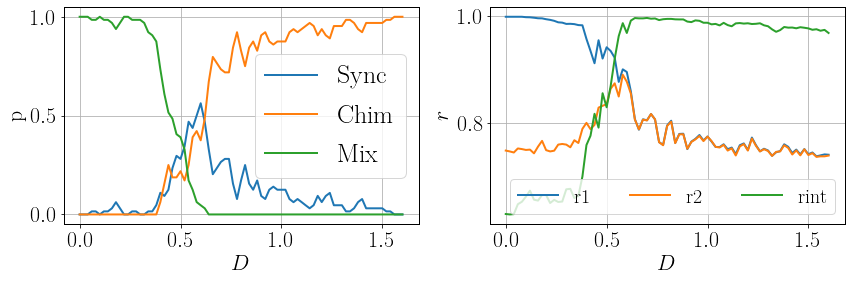

In [24]:
'''Plot probability of system being in a certain state after a given 
   transient time. As above but in the noisy case'''

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=False) 
path = 'output_of_cpp_file.txt'

data = pd.read_csv(path, sep='\t', names=['D', 'tau', 'fac', 'sig12', 'seed', 'Rint', 'delta', 'om', 'R1', 'R2'])

data['sync'] = data.apply(lambda row: state(row.R1, row.R2, 'sync') , axis=1)
data['chim'] = data.apply(lambda row: state(row.R1, row.R2, 'chim') , axis=1)
data['mix']  = data.apply(lambda row: state(row.R1, row.R2, 'mix')  , axis=1)
data['misc'] = data.apply(lambda row: state(row.R1, row.R2, 'misc') , axis=1)

data['mix1']  = data.apply(lambda row: state(row.R1, row.R2, 'mix1')  , axis=1)
data['mix2']  = data.apply(lambda row: state(row.R1, row.R2, 'mix2')  , axis=1)

synclist, chimlist, mixlist, misclist  = [], [], [], []
R1list, R2list, Rintlist = [], [], []

data0 = data
        
# Filter out initial conditions, which do not lead to 'mix' state
for s in range(41): 
    seed = round(s*100 + 377999, 1)
    datm = data[(data['seed'] < seed + 1) & (data['seed'] > seed - 1) & (data['D'] < 0.01)]
    if (datm['mix'].mean() < 0.99): data0 = data0[data0.seed != seed]
    
for D in range(81):
    Dfr = round(0.02*D, 2)
    data1 = data0[data0['D'] < Dfr + 0.001]
    data1 = data1[data1['D'] > Dfr - 0.001]

    data2 = data1[data1['tau'] < 0.001 ]
        
    synclist.append(round(data2['sync'].mean(), 3))
    chimlist.append(round(data2['chim'].mean(), 5))
    mixlist.append(round(data2['mix'].mean(), 3))
    misclist.append(round(data2['misc'].mean(), 3))

data_m = data
        
for s in range(41):
    seed = round(s*100 + 377999, 1)
    datm = data[(data['seed'] < seed + 1) & (data['seed'] > seed - 1) & (data['D'] < 0.01)]
        
    a = datm['mix'].mean()
                
    if not(a > 0.99):
        data_m = data_m.drop(data_m[data_m['seed'] == seed].index)
    
for D in range(81):
    Dfr = round(0.02*D, 2) 
        
    data1_m = data_m[data_m['D'] < Dfr + 0.001]
    data1_m = data1_m[data1_m['D'] > Dfr - 0.001]
        
    data2_m = data1_m[data1_m['tau'] < 0.001]
        
    Rintlist.append(round(data2_m['Rint'].mean(), 3))
    R1list.append(round(data2_m['R1'].mean(), 3))
    R2list.append(round(data2_m['R2'].mean(), 3))

Dlist = np.arange(0,1.62,0.02).tolist() 
    
ax1.plot(Dlist, smoothing(synclist, 0.5), 'tab:blue', linewidth=2, label=r'Sync') 
ax1.plot(Dlist, smoothing(chimlist, 0.5), 'tab:red', linewidth=2, label=r'Chim')
ax1.plot(Dlist, smoothing(mixlist, 0.5), 'tab:orange', linewidth=2, label=r'Mix')

ax1.legend(loc='best')
ax1.set_xlabel(r'$D$')
ax1.set_ylabel(r'p')

ax2.plot(Dlist, smoothing(R1list, 0.2), 'forestgreen', markersize=5,label=r'r1')
ax2.plot(Dlist, smoothing(R2list, 0.2), 'royalblue', markersize=5,label=r'r2')
ax2.plot(Dlist, smoothing(Rintlist, 0.2), 'darkorchid', markersize=5,label=r'rint')
ax2.set_ylabel(r'$r$')
ax2.set_xlabel(r'$D$')
ax2.legend(fontsize=20, loc='best', ncol=3)

## Colored noise

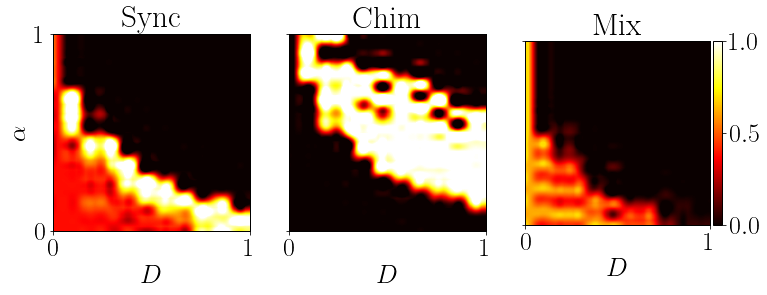

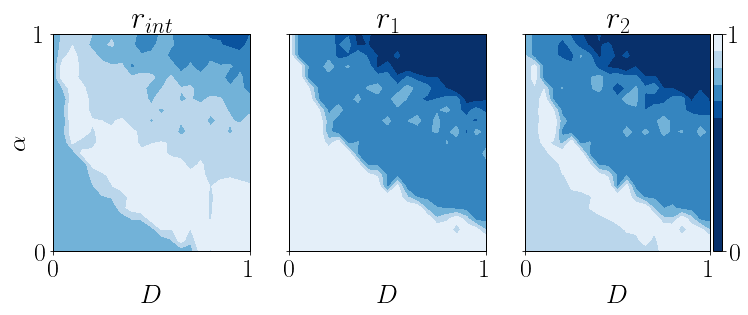

In [4]:
'''State plot as two parameter color plot'''

rc('text', usetex=True)
rc('xtick', labelsize=26)
rc('ytick', labelsize=26)
rc('font', size=26)
rc('axes', labelsize=26)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

path = 'output_of_cpp_file.txt'

data = pd.read_csv(path, sep='\t', names=['D', 'alpha', 'frac', 'sig12', 'seed', 'Rint', 'delta', 'om', 'R1', 'R2'])

data['sync'] = data.apply(lambda row: state(row.R1, row.R2, 'sync') , axis=1)
data['chim'] = data.apply(lambda row: state(row.R1, row.R2, 'chim') , axis=1)
data['mix']  = data.apply(lambda row: state(row.R1, row.R2, 'mix')  , axis=1)
data['misc'] = data.apply(lambda row: state(row.R1, row.R2, 'misc') , axis=1)

data['mix1']  = data.apply(lambda row: state(row.R1, row.R2, 'mix1') , axis=1)
data['mix2']  = data.apply(lambda row: state(row.R1, row.R2, 'mix2') , axis=1)

alphalist = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
             0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

normalizer=Normalize(0,1) 

synclist = []
chimlist = []
mixlist  = []
misclist = []
    
for D in range(21):
    Dfr = round(D*0.05, 1) 
    data1 = data[data['D']==Dfr]
    for t in range(21):
        alpha = alphalist[t]
        data2 = data1[data1['alpha'] < alpha + 0.001 ]
        data2 = data2[data2['alpha'] > alpha - 0.001 ]
        
        synclist.append(round(data2['sync'].mean(), 3))
        chimlist.append(round(data2['chim'].mean(), 3))
        mixlist.append(round(data2['mix'].mean(), 3))
        misclist.append(round(data2['misc'].mean(), 3))

z = np.array(synclist) 
z = z.reshape(21, 21)
z = np.array(z).T

im = ax1.imshow(z, extent=(0, 0.1, 0, 0.1), norm=normalizer, cmap='hot', interpolation='sinc')

ax1.set_xlabel(r'$D$', rotation= 0)
ax1.set_xticks([0.0,0.1])
ax1.set_xticklabels([r'0',r'1'])
ax1.set_ylabel(r'$\alpha$')
ax1.set_yticks([0.1,0.0])
ax1.set_yticklabels([r'0',r'1'])
ax1.set_title(r'Sync')
ax1.invert_yaxis()

z2 = np.array(chimlist) 
z2 = z2.reshape(21, 21)
z2 = np.array(z2).T

im2 = ax2.imshow(z2, extent=(0, 0.1, 0, 0.1), norm=normalizer, cmap='hot', interpolation='sinc') 
ax2.set_xlabel(r'$D$', rotation= 0)
ax2.set_xticks([0.0,0.1])
ax2.set_xticklabels([r'0',r'1'])
ax2.set_title(r'Chim') 
ax2.invert_yaxis()

z3 = np.array(mixlist) 
z3 = z3.reshape(21, 21)
z3 = np.array(z3).T

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
im3 = ax3.imshow(z3, extent=(0, 0.1, 0, 0.1), norm=normalizer, cmap='hot', interpolation='sinc') 
ax3.set_xlabel(r'$D$', rotation= 0)
ax3.set_xticks([0.0,0.1])
ax3.set_xticklabels([r'0',r'1'])
ax3.set_title(r'Mix') 
ax3.invert_yaxis()

cbar = f.colorbar(im3, cax=cax, orientation='vertical')

plt.show()

list1 = ['mixed', 'chimera', 'synchronised', 'layer 1 chim and layer 2 sync', 'layer 1 sync and layer 2 chim', 'all']
list2 = ['mixed', 'chimera', 'synchronised', 'l1_chim_l2_sync', 'l1_sync_l2_chim', 'all']

for i in range(1):  
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    
    data_m = data
    for s in range(21):
        seed = round(s*100 + 377999, 1)
        datm = data[(data['seed'] == seed) & (data['D'] < 0.01) & (data['alpha'] < 1.001)] # data['alpha'] < 0.001 !!!
        
        if i == 0: a = datm['mix'].mean()
        elif i == 1: a = datm['chim'].mean()
        elif i == 2: a = datm['sync'].mean()
        elif i == 3: a = datm['mix1'].mean()
        elif i == 4: a = datm['mix2'].mean()
        elif i == 5: a = 1
            
    Rintlist = []
    R1list   = []
    R2list   = []
    
    for D in range(21):
        Dfr = round(D*0.05, 2)
        data1_m = data_m[data_m['D']==Dfr]
        for t in range(21):
            alpha = alphalist[t]
            data2_m = data1_m[data1_m['alpha'] < alpha + 0.001]
            data2_m = data2_m[data2_m['alpha'] > alpha - 0.001]
        
            Rintlist.append(round(data2_m['Rint'].mean(), 3))
            R1list.append(round(data2_m['R1'].mean(), 3))
            R2list.append(round(data2_m['R2'].mean(), 3))
            
            normalizer=Normalize(0.6,1)

    z = np.array(Rintlist) 
    z = z.reshape(21, 21)
    z = np.array(z).T

    levels = np.linspace(0,1,14)

    im = ax1.contourf(z, levels, norm=normalizer, cmap=rev_blues)

    ax1.set_xlabel(r'$D$', rotation= 0)
    ax1.set_xticks([0.0,20])
    ax1.set_xticklabels([r'0',r'1'])
    ax1.set_ylabel(r'$\alpha$')
    ax1.set_yticks([0,20])
    ax1.set_yticklabels([r'0',r'1'])
    ax1.set_title(r'$r_{int}$')

    z2 = np.array(R1list) 
    z2 = z2.reshape(21, 21)
    z2 = np.array(z2).T
    
    im2 = ax2.contourf(z2, levels, norm=normalizer, cmap=rev_blues)
    
    ax2.set_xlabel(r'$D$', rotation= 0)
    ax2.set_xticks([0,20])
    ax2.set_xticklabels([r'0',r'1'])
    ax2.set_title(r'$r_1$') 

    z3 = np.array(R2list) 
    z3 = z3.reshape(21, 21)
    z3 = np.array(z3).T

    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im3 = ax3.contourf(z3, levels, norm=normalizer, cmap=rev_blues)
    
    ax3.set_xlabel(r'$D$', rotation= 0)
    ax3.set_xticks([0,20]) 
    ax3.set_xticklabels([r'0',r'1'])
    ax3.set_title(r'$r_2$') 

    cbar = f.colorbar(im3, cax=cax, ticks=[0, 1], orientation='vertical') 
    
    plt.show()

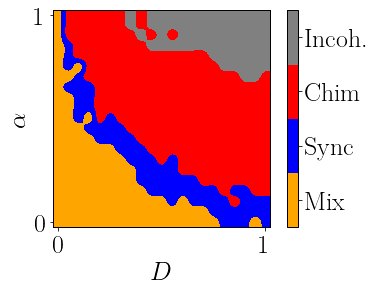

In [5]:
'''State plot as two parameter color plot for a single seed (initial condition)'''

rc('text', usetex=True)
rc('xtick', labelsize=26)
rc('ytick', labelsize=26)
rc('font', size=26)
rc('axes', labelsize=26)

path = 'cpp_file_output.txt'

data = pd.read_csv(path, sep='\t', names=['D', 'tau', 'frac', 'sig12', 'seed', 'Rint', 'delta', 'om', 'R1', 'R2'])

s = 6 
seed = str(round(377999 + s*100, 1))
data = data[data['seed'] == 377999 + s*100]

data['states'] = data.apply(lambda row: states(row.R1, row.R2) , axis=1)
data = data.sort_values('states').drop_duplicates(subset=['D', 'tau'], keep='last')
data = data.sort_values(by=['tau','D'])

zs = np.array(data['states']) 
zs = zs.reshape(21, 21)

cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

fig,ax = plt.subplots()
im = ax.imshow(zs, cmap=cm, norm=norm, interpolation='spline16')

ax.set_xlabel(r'$D$', rotation= 0)
ax.set_xticks([0,20])
ax.set_xticklabels([r'0',r'1'])
ax.set_yticks([0,20])
ax.set_ylabel(r'$\alpha$')
ax.set_yticklabels([r'0',r'1'])
ax.invert_yaxis()

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(im, format=fmt, ticks=tickz)
plt.show()

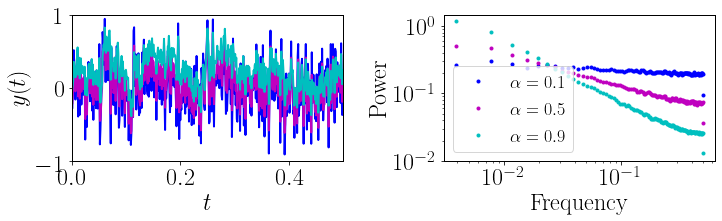

In [6]:
rc('xtick', labelsize=24)
rc('ytick', labelsize=24)
rc('font', size=24)
rc('axes', labelsize=24)

x = np.arange(0, 200, 0.001).tolist()

y1 = np.loadtxt('output_of_cpp_file1.txt').tolist()
y2 = np.loadtxt('output_of_cpp_file2.txt').tolist()
y3 = np.loadtxt('output_of_cpp_file2.txt').tolist()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(0.9*12, 0.9*4), sharey=False)

ax1.plot(x, y1,'-b', label=r'$\alpha = 0.1$')
ax1.plot(x, y2,'-m', label=r'$\alpha = 0.5$')
ax1.plot(x, y3,'-c', label=r'$\alpha = 0.9$')

ax1.set_xlim(0,0.5)
ax1.set_ylim(-1,1)
ax1.set_ylabel(r'$y(t)$')
ax1.set_xlabel(r'$t$')

freqs, psd = signal.welch(y1)
freqs2, psd2 = signal.welch(y2)
freqs3, psd3 = signal.welch(y3)

ax2.loglog(freqs, psd, '.b', label=r'$\alpha = 0.1$')
ax2.loglog(freqs2, psd2, '.m', label=r'$\alpha = 0.5$')
ax2.loglog(freqs3, psd3, '.c', label=r'$\alpha = 0.9$')

ax2.set_xlabel('Frequency')
ax2.set_ylabel('Power')
ax2.legend(fontsize=18, loc='best')
ax2.set_yticks([0.01,0.1,1])

f.tight_layout()

<ipython-input-53-de9254e31222>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


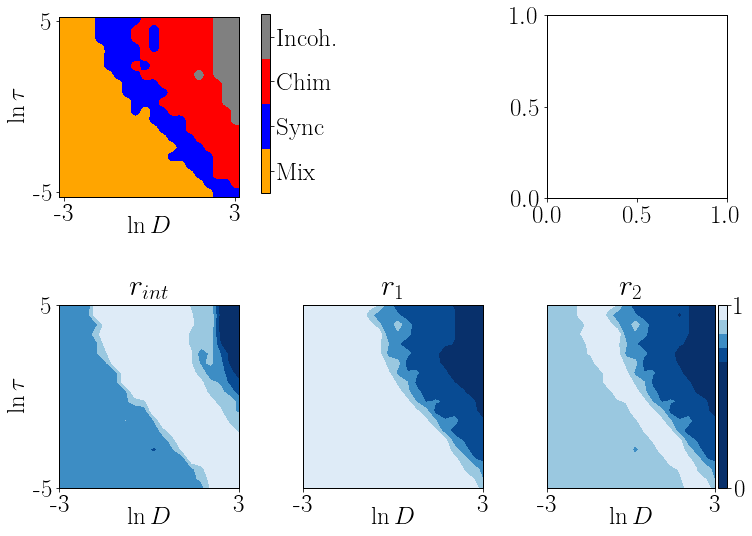

In [53]:
'''A final tidy Gridspec plot'''

rc('text', usetex=True)
rc('xtick', labelsize=25)
rc('ytick', labelsize=25)
rc('font', size=25)
rc('axes', labelsize=25)

fig=plt.figure(figsize=[11,8]) 
gs = gridspec.GridSpec(2,3, figure=fig)

plt.subplots_adjust(wspace=-1, hspace=-1)

ax11=fig.add_subplot(gs[0,0]) 
ax12=fig.add_subplot(gs[0,2])

ax21=fig.add_subplot(gs[1,0]) 
ax22=fig.add_subplot(gs[1,1]) 
ax23=fig.add_subplot(gs[1,2]) 

im = ax11.imshow(z, cmap=cm, norm=norm, interpolation='spline16')

ax11.set_xlabel(r'$\ln D$', rotation= 0, labelpad=-10)
ax11.set_xticks([0,19])
ax11.set_xticklabels([r'-3',r'3'])
ax11.set_yticks([0,19])
ax11.set_ylabel(r'$\ln \tau$')
ax11.set_yticklabels([r'-5',r'5'])
ax11.invert_yaxis()

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([(0.355), (0.63), (0.011), (0.31)])
cb = fig.colorbar(im, format=fmt, ticks=tickz, cax=cbar_ax)

z = np.array(Rintlist) 
z = z.reshape(20, 20)
z = np.array(z).T

levels = np.linspace(0,1,14)

im = ax21.contourf(z, levels, norm=normalizer, cmap=rev_blues)

ax21.set_xlabel(r'$\ln D$', rotation= 0, labelpad=-10)
ax21.set_xticks([0.0,19])
ax21.set_xticklabels([r'-3',r'3'])
ax21.set_ylabel(r'$\ln \tau$')
ax21.set_yticks([0,19])
ax21.set_yticklabels([r'-5',r'5'])
ax21.set_title(r'$r_{int}$', y=1.03)

z2 = np.array(R1list) 
z2 = z2.reshape(20, 20)
z2 = np.array(z2).T
    
im2 = ax22.contourf(z2, levels, norm=normalizer, cmap=rev_blues)
    
ax22.set_xlabel(r'$\ln D$', rotation= 0, labelpad=-10)
ax22.set_xticks([0,19])
ax22.set_yticks([]) 
ax22.set_xticklabels([r'-3',r'3'])
ax22.set_title(r'$r_1$', y=1.03) 

z3 = np.array(R2list) 
z3 = z3.reshape(20, 20)
z3 = np.array(z3).T

divider = make_axes_locatable(ax23)
cax = divider.append_axes('right', size='5%', pad=0.05)
    
im3 = ax23.contourf(z3, levels, norm=normalizer, cmap=rev_blues)
    
ax23.set_xlabel(r'$\ln D$', rotation= 0, labelpad=-10)
ax23.set_xticks([0,19]) 
ax23.set_yticks([]) 
ax23.set_xticklabels([r'-3',r'3'])
ax23.set_title(r'$r_2$', y=1.03) 

cbar = f.colorbar(im3, cax=cax, ticks=[0, 1], orientation='vertical')

fig.tight_layout()